In [1]:
import folium, altair as alt, geopandas as gpd, fiona, pandas as pd, requests, json
alt.renderers.enable('jupyterlab')

RendererRegistry.enable('jupyterlab')

In [2]:
print(folium.__version__)

0.6.0+71.g5706269


In [3]:
income = pd.read_csv(r"https://raw.githubusercontent.com/pri-data/50-states/master/data/income-counties-states-national.csv", dtype={"fips":str})
income['income-2015']=pd.to_numeric(income['income-2015'], errors='coerce')

In [4]:
income.head()

,fips,county,state,income-2015,income-1989a,income-1989b,change
0,00000,US,US,55775.0,28906,53367.28102,4.316843
1,01000,Alabama,AL,44833.0,22202,40990.11877,8.571546
2,01001,Autauga County,AL,56580.0,26898,49660.04030,12.230399
3,01003,Baldwin County,AL,52387.0,24043,44389.03818,15.267074
4,01005,Barbour County,AL,31433.0,18673,34474.75398,-9.676945


In [5]:
states = gpd.GeoDataFrame.from_features(requests.get(r"https://raw.githubusercontent.com/jtbaker/data/master/geodata/usstates.geojson").json(), crs=fiona.crs.from_epsg(4326))

states.head()

,CENSUSAREA,GEO_ID,LSAD,NAME,STATE,geometry
0,30842.923,0400000US23,,Maine,23,"(POLYGON ((-67.619761 44.519754, -67.61541 44...."
1,7800.058,0400000US25,,Massachusetts,25,"(POLYGON ((-70.832044 41.606504, -70.823735 41..."
2,56538.901,0400000US26,,Michigan,26,"(POLYGON ((-88.684434 48.115785, -88.675628 48..."
3,145545.801,0400000US30,,Montana,30,"POLYGON ((-104.057698 44.997431, -104.250145 4..."
4,109781.180,0400000US32,,Nevada,32,"POLYGON ((-114.0506 37.000396, -114.049995 36...."


In [6]:
abbrs = pd.read_json(json.dumps(requests.get('https://gist.githubusercontent.com/tvpmb/4734703/raw/b54d03154c339ed3047c66fefcece4727dfc931a/US%2520State%2520List').json()))

abbrs.head(3)

,alpha-2,name
0,AL,Alabama
1,AK,Alaska
2,AZ,Arizona


In [7]:
statesmerge = states.merge(abbrs,how='left', left_on='NAME', right_on='name')
statesmerge['geometry']=statesmerge.geometry.simplify(.05)

statesmerge.head()

,CENSUSAREA,GEO_ID,LSAD,NAME,STATE,geometry,alpha-2,name
0,30842.923,0400000US23,,Maine,23,"(POLYGON ((-67.619761 44.519754, -67.582113000...",ME,Maine
1,7800.058,0400000US25,,Massachusetts,25,"(POLYGON ((-70.832044 41.606504, -70.823735 41...",MA,Massachusetts
2,56538.901,0400000US26,,Michigan,26,"(POLYGON ((-88.684434 48.115785, -88.418244 48...",MI,Michigan
3,145545.801,0400000US30,,Montana,30,"POLYGON ((-104.057698 44.997431, -111.055199 4...",MT,Montana
4,109781.180,0400000US32,,Nevada,32,"POLYGON ((-114.0506 37.000396, -114.046838 36....",NV,Nevada


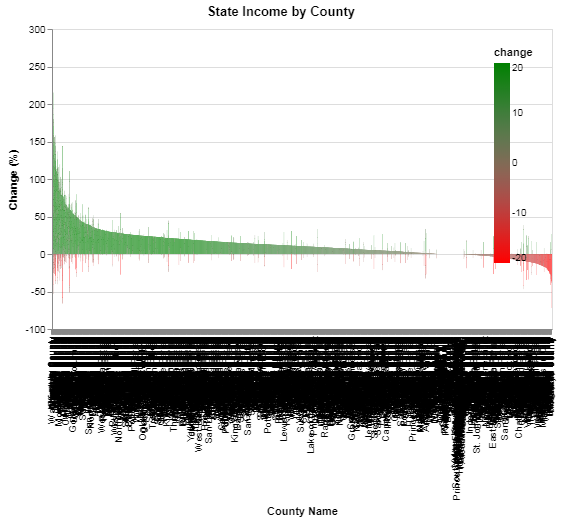

In [10]:
basechart = alt.Chart(income, title='State Income by County').mark_bar().encode(
    x=alt.X('county:N', title='County Name', sort=alt.EncodingSortField(op='sum', field='change', order='descending')), 
    y=alt.Y('change:Q', title='Change (%)'), 
    color=alt.Color('change:Q', scale=alt.Scale(domain=[-20,0,20], range=['red', 'grey', 'green']), legend=alt.Legend(orient=alt.LegendOrient('top-right'))),
    tooltip=[alt.Tooltip('county:N',title='County'),
             alt.Tooltip('state:N', title='State'), 
             alt.Tooltip('change:Q', format=".2f", title='Change'), 
             alt.Tooltip('income-2015:Q', format="$,.2f", title='Income - 2015')]
).properties(width=500)

basechart

In [ ]:
m = folium.Map(location=[35.3,-97.6], zoom_start=4)

g = folium.GeoJson(statesmerge, style_function=lambda x: {'fillColor':"transparent", "color":'black'}, 
                   tooltip=folium.features.GeoJsonTooltip(fields=["NAME"])).add_to(m)

pop = folium.features.GeoJsonPopup(fields=["NAME"],
                                   labels=False,
                                   vegalite=folium.VegaLite(basechart), 
                                   map_key='alpha-2',
                                   data_key='state',
                                   max_width=800,
                                   style='font-size: 20pt; margin: auto;',
                                   class_name='foliumPopup'
                                  )
g.add_child(pop)

m

